# exp053_train
[Notion](https://www.notion.so/exp053-16b36166ba95457d81965546a6ef959b?pvs=4)  
liverのみモデル. loss weightあり
Copy from: exp049_train <- exp031_train <- exp024_train <- exp014_train <- exp009_train <- exp008_train <- exp007_train  


In [1]:
import os
import random
import sys
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
from typing import Tuple

import albumentations as A
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.cuda.amp as amp
from sklearn.model_selection import GroupKFold
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# リポジトリtopに移動
while os.path.basename(os.getcwd()) != 'rsna-2023':
    os.chdir('../')
    if os.getcwd() == '/':
        raise Exception('Could not find project root directory.')

from src.classification.dataset import TrainDatasetSolidOrgans as TrainDataset
from src.classification.dataset import save_df
from src.image_processing import windowing
from src.logger import get_logger
from src.loss import BCEDiceLoss, DiceCoef
from src.classification.model import lock_model_encoder_weight
from src.classification.trainer import fit_model
from src.samplar import MultilabelBalancedRandomSampler
from models.efficientnet_pytorch_3d import EfficientNet3D

# Config

In [2]:
class CFG:
    exp_name = 'exp_053'
    # model config
    # timm backbone
    backbone = 'efficientnet-b4'
    n_ch = 1
    expand_ch_dim = True
    # n_class: healthy, low, high
    n_class = 3
    # hyper params
    ww = 1000
    wl = 0
    init_lr = 1e-3
    min_lr = 1e-6
    weight_decay = 1e-4
    image_size = (96, 224, 224)
    batch_size = 32
    amp = True
    eps = 1e-6
    n_epoch = 24
    pretrain = False
    freeze_epochs = 0
    noaug_epochs = 1
    # fold config
    n_fold = 6
    include_evaluation = False
    train_folds = 1
    # path
    image_dir = "data/dataset002"
    model_save_dir = "outputs"
    # other config
    seed = 42
    num_workers = 2
    num_gpus = 2
    progress_bar = True
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    class_weight=torch.tensor([1.0, 2.0, 4.0]).to(device)

In [3]:
# create output dir
os.makedirs(os.path.join(CFG.model_save_dir, CFG.exp_name), exist_ok=True)

# get label correspondences
organ_index_dict_inv = {
    0: 'liver',
    1: 'spleen',
    2: 'kidney',
    3: 'bowel'
}
organ_index_dict = {v: k for k, v in organ_index_dict_inv.items()}

# seed setting
def seed_everything(seed=CFG.seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything()

# logger setting
logger = get_logger(CFG)

# load dataframe
df_train = pd.read_csv('data/rsna-2023-abdominal-trauma-detection/train.csv')
df_train_image_level = pd.read_csv('data/rsna-2023-abdominal-trauma-detection/image_level_labels.csv')
df_train_series_meta = pd.read_csv('data/rsna-2023-abdominal-trauma-detection/train_series_meta.csv')

# Dataset

In [4]:
def get_training_dataframe():
    """データセットのDataFrameを作成する.
    データセットによって内容を書き換える必要あり.
    """
    # df_seg_info_imageをベースに、学習用データフレームを構築.
    # df_seg_info_imageは、exp002で作成されるcsvファイル.
    path_dict = defaultdict(list)
    for i in range(len(df_train_series_meta)):
        sr = df_train_series_meta.iloc[i]
        pid, sid = int(sr["patient_id"]), int(sr["series_id"])

        sr_label = df_train[df_train["patient_id"] == pid].iloc[0]
        for organ in ["liver", "spleen", "kidney"]:
            image_path = os.path.join(CFG.image_dir, str(pid), str(sid), f"{organ}.npy")
            path_dict["patient_id"].append(pid)
            path_dict["series_id"].append(sid)
            path_dict["organ"].append(organ)
            path_dict["image_path"].append(image_path)
            path_dict["healthy"].append(sr_label[organ+"_healthy"])
            path_dict["low"].append(sr_label[organ+"_low"])
            path_dict["high"].append(sr_label[organ+"_high"])


    # 画像データのDataFrameを作成
    df = pd.DataFrame(path_dict)

    # 画像データのDataFrameに、foldの情報を追加.
    # 正しいデータ分割のため、患者IDごとに分ける.
    df['fold'] = -1
    gkf = GroupKFold(n_splits=CFG.n_fold)
    for fold, (train_idx, val_idx) in enumerate(gkf.split(df, groups=df['patient_id'])):
        df.loc[val_idx, 'fold'] = fold

    # fold分けを統一するためにここで臓器を限定
    df = df[df["organ"] == "liver"].reset_index(drop=True)
    
    return df

In [5]:
df = get_training_dataframe()
save_df(df, CFG)
df.head()

,patient_id,series_id,organ,image_path,healthy,low,high,fold
0,10004,21057,liver,data/dataset002/10004/21057/liver.npy,1,0,0,1
1,10004,51033,liver,data/dataset002/10004/51033/liver.npy,1,0,0,1
2,10005,18667,liver,data/dataset002/10005/18667/liver.npy,1,0,0,5
3,10007,47578,liver,data/dataset002/10007/47578/liver.npy,1,0,0,0
4,10026,29700,liver,data/dataset002/10026/29700/liver.npy,1,0,0,4


In [6]:
def apply_preprocess(image: np.ndarray)-> np.ndarray:
    """データ前処理. カスタマイズして使用.
    Args:
        image (numpy.ndarray): HU値のCT画像.
    Returns:
        image (numpy.ndarray): windowing及び0~1に正規化.
    """
    # 0~1に正規化
    image = windowing(image, wl=0, ww=1000, mode="float32")
    return image

def get_aug():
    """データ拡張. カスタマイズして使用.
    Note:
        画像のResizeはDataset側で行うので、この関数に入れる必要はない.
    """
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(
                shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5
            ),
            A.OneOf(
                [
                    A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
                    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0),
                ],
                p=0.25,
            ),
            A.CoarseDropout(
                max_holes=8,
                max_height=CFG.image_size[0] // 20,
                max_width=CFG.image_size[1] // 20,
                min_holes=5,
                fill_value=0,
                mask_fill_value=0,
                p=0.5,
            ),
        ],
        p=1.0,
    )

In [7]:
ds = TrainDataset(CFG, df, preprocess=apply_preprocess, tfms=get_aug())

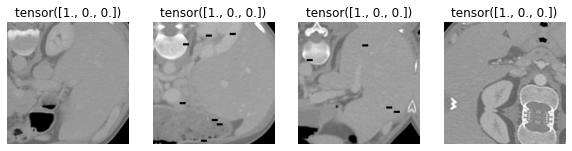

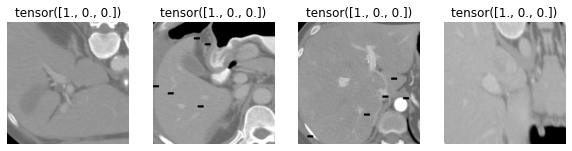

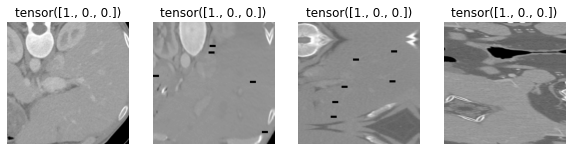

In [8]:
for i in range(3):
    fig, ax = plt.subplots(1, 4, figsize=(10, 5))
    for j in range(4):
        img, label = ds[random.randint(0, len(ds)-1)]
        ax[j].imshow(img.numpy()[0, img.shape[1]//2], cmap='gray')
        ax[j].set_title(label)

    for j in range(4):
        ax[j].grid(False)
        ax[j].axis(False)

In [9]:
result_dict = {}

for fold in range(CFG.train_folds):
    logger.info(f"Fitting on Fold {fold+1}")
    # Dataset
    if CFG.include_evaluation: # evaluation用のデータを最後のfoldに含める場合
        df_train = df[(df["fold"] != fold) & (df["fold"] != CFG.n_fold-1)].reset_index(drop=True)
        df_valid = df[df["fold"] == fold].reset_index(drop=True)
    else:
        df_train = df[df["fold"] != fold].reset_index(drop=True)
        df_valid = df[df["fold"] == fold].reset_index(drop=True)
    train_data = TrainDataset(
        CFG, df_train, preprocess=apply_preprocess, tfms=get_aug()
    )
    valid_data = TrainDataset(CFG, df_valid, preprocess=apply_preprocess, tfms=None)

    # Sampler
    # 各クラスを均等に学習することで、効率的に学習する.
    """train_sampler = MultilabelBalancedRandomSampler(
        CFG,
        df_train[['liver', 'spleen', 'kidney', 'bowel', 'any_inv']].to_numpy(),
        class_choice="random",
        num_iteration=CFG.iteration_per_epoch
    )
    valid_sampler = MultilabelBalancedRandomSampler(
        CFG,
        df_valid[['liver', 'spleen', 'kidney', 'bowel', 'any_inv']].to_numpy(),
        class_choice="random",
        num_iteration=CFG.iteration_per_epoch//5
    )"""

    # Data Loader
    train_iterator = DataLoader(
        train_data,
        shuffle=True, # sampler=train_sampler,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        pin_memory=True,
    )
    valid_iterator = DataLoader(
        valid_data,
        shuffle=True, # sampler=valid_sampler,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        pin_memory=True,
    )

    # noaug_iterator
    train_noaug_data = TrainDataset(
        CFG, df_train, preprocess=apply_preprocess, tfms=None
    )
    train_noaug_iterator = DataLoader(
        train_noaug_data,
        shuffle=True, # sampler=train_sampler,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        pin_memory=True,
    )

    if CFG.amp:
        model = EfficientNet3D.from_name(
            CFG.backbone, 
            override_params={'num_classes': CFG.n_class}, 
            in_channels=CFG.n_ch
        ).to(CFG.device)
        scaler = amp.GradScaler()
    else:
        model = EfficientNet3D.from_name(
            CFG.backbone, 
            override_params={'num_classes': CFG.n_class}, 
            in_channels=CFG.n_ch
        ).to(CFG.device)
        scaler = None
    if CFG.num_gpus > 1:
        model = nn.DataParallel(model)

    model_name = f"{CFG.exp_name}_f{fold}"

    if CFG.freeze_epochs:
        logger.info("+-+-+-+-+-+-+-+-+")
        logger.info("pretrain mode")
        logger.info("+-+-+-+-+-+-+-+-+")

        loss_criterion = nn.BCEWithLogitsLoss(CFG.class_weight)
        opt = AdamW(model.parameters(), lr=CFG.init_lr, eps=CFG.eps)
        scheduler = None

        model = lock_model_encoder_weight(model, mode="lock")

        _ = fit_model(
            CFG,
            model,
            model_name,
            train_iterator,
            train_noaug_iterator,
            valid_iterator,
            opt,
            loss_criterion,
            True,
            scaler,
            logger,
            scheduler,
            organ_index_dict_inv
        )

    logger.info("@*@*@*@*@*@*@*@*@")
    logger.info("fulltrain mode")
    logger.info("@*@*@*@*@*@*@*@*@")

    loss_criterion = nn.BCEWithLogitsLoss(CFG.class_weight)
    opt = AdamW(model.parameters(), lr=CFG.init_lr, weight_decay=CFG.weight_decay, eps=CFG.eps)
    scheduler = CosineAnnealingLR(opt, CFG.n_epoch, eta_min=CFG.min_lr)

    model = lock_model_encoder_weight(model, mode="unlock")
    
    tr_loss, val_loss, val_metrics = fit_model(
        CFG,
        model,
        model_name,
        train_iterator,
        train_noaug_iterator,
        valid_iterator,
        opt,
        loss_criterion,
        False,
        scaler,
        logger,
        scheduler,
        organ_index_dict_inv
    )

    result = {
        "tr_loss": tr_loss, 
        "val_loss": val_loss, 
        "val_metrics": val_metrics,
    }
    result_dict[model_name] = result

2023-10-09 20:59:08,740 INFO: Fitting on Fold 1
2023-10-09 20:59:08,823 INFO: @*@*@*@*@*@*@*@*@
2023-10-09 20:59:08,824 INFO: fulltrain mode
2023-10-09 20:59:08,824 INFO: @*@*@*@*@*@*@*@*@
Validation loss: 1.08688: 100%|██████████| 25/25 [00:58<00:00,  2.33s/it]
2023-10-09 21:06:37,214 INFO: Epoch: 01 | Epoch Time: 7m 28s
2023-10-09 21:06:37,214 INFO: lr:0.0010000
2023-10-09 21:06:37,215 INFO: Train Loss: 0.549
2023-10-09 21:06:37,215 INFO: Val. Loss: 1.054 | Val. Logloss Score : 0.812,
Validation loss: 0.63990: 100%|██████████| 25/25 [00:58<00:00,  2.33s/it]
2023-10-09 21:13:53,253 INFO: Epoch: 02 | Epoch Time: 7m 16s
2023-10-09 21:13:53,253 INFO: lr:0.0009957
2023-10-09 21:13:53,254 INFO: Train Loss: 0.476
2023-10-09 21:13:53,254 INFO: Val. Loss: 0.586 | Val. Logloss Score : 0.507,
Validation loss: 0.06878: 100%|██████████| 25/25 [00:55<00:00,  2.20s/it]
2023-10-09 21:20:57,469 INFO: Epoch: 03 | Epoch Time: 7m 4s
2023-10-09 21:20:57,470 INFO: lr:0.0009830
2023-10-09 21:20:57,470 INFO

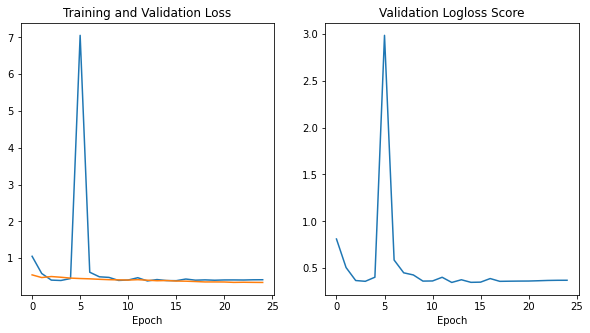

In [10]:
for fold in range(CFG.train_folds):
    model_name = f"{CFG.exp_name}_f{fold}"
    val_loss = result_dict[model_name]["val_loss"]
    val_dice = result_dict[model_name]["val_metrics"]
    tr_loss = result_dict[model_name]["tr_loss"]

    fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    ax[0].plot(val_loss)
    ax[0].plot(tr_loss)
    ax[0].set_title('Training and Validation Loss')
    ax[0].set_xlabel('Epoch')

    ax[1].plot(val_dice)
    ax[1].set_title('Validation Logloss Score')
    ax[1].set_xlabel('Epoch')

# Validation

In [11]:
import cv2
from typing import Any, Optional, Dict

from src.data_io import load_dicom_series
from src.segmentation.dataset import TestDataset as SegTestDataset
from src.segmentation.model import load_models as seg_load_models
from src.segmentation.trainer import inference as seg_inference
from src.classification.dataset import TestDatasetBowelExtra, TestDatasetSolidOrgans
from src.image_processing import apply_preprocess, crop_organ, kidney_split, resize_volume, apply_postprocess, kidney_specific, resize_3d, resize_1d
from src.classification.model import load_models as cls_load_models
from src.classification.trainer import inference as cls_inference
from src.metrics import score, create_training_solution, normalize_probabilities_to_one
from src.classification.dataset import load_df

In [12]:
# organs dict (for SEG and LSK models)
organ_index_dict_inv = {
    0: 'liver',
    1: 'spleen',
    2: 'kidney',
    3: 'bowel'
}
organ_index_dict = {v: k for k, v in organ_index_dict_inv.items()}

# labels dict (for BE models)
label_index_dict_inv = {
    0: 'bowel',
    1: 'extravasation'
}

def load_series_from_dataset(dir_: str, max_slices: Optional[int]=None)-> np.ndarray:
    """seriesを読み込む."""
    path_list = os.listdir(dir_)
    path_list = [[int(path.replace(".npy","")), path] for path in path_list]
    path_list.sort()
    path_list = [path[1] for path in path_list]
    if max_slices is not None:
        step = (len(path_list) + max_slices - 1) // max_slices
        path_list = path_list[::step]
    arr = []
    for path in path_list:
        arr.append(np.load(os.path.join(dir_, path)))
    return np.array(arr)

def load_image(path: str) -> np.ndarray:
    """画像の読み込み.
    Args:
        path (str): 画像のパス.
    Returns:
        numpy.ndarray: 画像.
    Note:
        現在読み込む画像の形式は.png, .npy, .npzのみ対応.
        cv2.IMREAD_UNCHANGED: 16bit画像やアルファチャンネルを考慮した読み込み.
    """
    if path.endswith(".png"):
        image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    elif path.endswith(".npy"):
        image = np.load(path)
    elif path.endswith(".npz"):
        image = np.load(path)["arr_0"]
    else:
        raise Exception(f"unexpected image format: {path}")
    return image

In [13]:
class CFG_INF:
    exp_name = 'exp_032'
    # evaluation時：'train', submission時：'test'
    phase = 'train'
    base_dir = 'data/rsna-2023-abdominal-trauma-detection'
    image_dir = f'data/rsna-2023-abdominal-trauma-detection/{phase}_images'
    # dataframeはこのconfigにもたせ、phaseで対応できるようにする.
    if phase == 'train':
        df = pd.read_csv(os.path.join(base_dir, 'train.csv'))
    elif phase == 'test':
        df = pd.read_csv(os.path.join(base_dir, 'sample_submission.csv'))
    df_series_meta = pd.read_csv(os.path.join(base_dir, f'{phase}_series_meta.csv'))
    image_size = (512, 512)
    # sample submissionで極端にスライス数が少ない場合があるため対応.
    min_slices = 10
    # 推論時間制限のため
    max_slices = 500
    max_series = 2
    model_save_dir = "outputs"
    lsk_model_mode = 'final'
    be_model_mode = 'final'

In [14]:
class Inference:
    """推論パイプライン."""
    def __init__(self,CFG_INF: Any, CFG_LSK: Any,):
        self.CFG_INF = CFG_INF
        self.CFG_LSK = CFG_LSK
        # self.CFG_BE = CFG_BE
        
        self.lsk_models = cls_load_models(CFG_LSK, mode=self.CFG_INF.lsk_model_mode)
        # self.be_models = cls_load_models(CFG_BE, mode=self.CFG_INF.be_model_mode, framework="timm")
    
    def __call__(self, pid: int) -> tuple:
        """inference process.
        1. load images from dicom files.
        2. create segmentation masks.
        3. create liver, spleen, kidney volumes.
        4. inference lsk models.
        5. inference be models.
        Args:
            pid (int): patient id.
        Return example:
            dict: {
            'pid': 0,
            'bowel_healthy': 0.0,
            'bowel_injury': 0.0,
            'extravasation_healthy': 0.0,
            'extravasation_injury': 0.0,
            'kidney_healthy': 0.0,
            'kidney_low': 0.0,
            'kidney_high': 0.0,
            'liver_healthy': 0.0,
            'liver_low': 0.0,
            'liver_high': 0.0,
            'spleen_healthy': 0.0,
            'spleen_low': 0.0,
            'spleen_high': 0.0
            }
        Note:
            - １症例に複数シリーズ存在する場合、各シリーズに対して推論を行い、全予測結果の最大値を採用する.
            - 推論時間的に厳しければ、最初のシリーズのみを採用するなど検討.
        """
        df_study = self.CFG_INF.df_series_meta[self.CFG_INF.df_series_meta['patient_id']==pid].reset_index(drop=True)
        # df_study内のそれぞれのシリーズを取得して、画像枚数に対して降順にソート.
        df_study = self.get_slices_and_sort(df_study)
        preds = defaultdict(list)
        for sid in df_study['series_id'].to_list()[:self.CFG_INF.max_series]:
            data = self.load_data(pid, sid)
            if data is None:
                continue
            lsk_preds = self.lsk_prediction(pid, sid)
            be_preds = self.be_prediction(data)
            for idx, organ in organ_index_dict_inv.items():
                if idx == 3:
                    continue
                preds[organ].append(lsk_preds[idx])
            for idx, label in label_index_dict_inv.items():
                pred = np.array([be_preds[idx]])
                preds[label].append(pred)

        ret = {'patient_id': pid}
        for k,v in preds.items():
            v = np.array(v)
            ret[k] = np.max(v, axis=0)
        ret = self.convert_submission_format(ret)
        return ret

    def load_data(self, pid: int, sid: int)-> np.ndarray:
        """dicomから画像を読み込む.
        Args:
            pid (int): patient id.
            sid (int): series id.
        Returns:
            np.ndarray: (Z, H, W) normalized CT series.
        Note:
            - preprocessは全モデル共通なので、ここで行う.
            - H, Wはすべてself.CFG_INF.image_sizeにresizeされる.
        """
        series_path = os.path.join('data/dataset001', 'train_images', str(pid), str(sid))
        # sample submissionでこういう例が存在する.
        if not os.path.exists(series_path):  
            return None
        image_arr = load_series_from_dataset(series_path, self.CFG_INF.max_slices)
        image_arr = apply_preprocess(image_arr, resize=self.CFG_INF.image_size)
        # sample submission対応
        if len(image_arr) < self.CFG_INF.min_slices:
            image_arr = resize_1d(image_arr, self.CFG_INF.min_slices, axis=0)
        return image_arr
    
    def get_slices_and_sort(self, df_study: pd.DataFrame)-> pd.DataFrame:
        """シリーズのスライス数を取得して、スライス数に対して降順にソートする.
        Args:
            df_study (pd.DataFrame): series meta dataframe.
        Returns:
            pd.DataFrame: sorted series meta dataframe.
        """
        pid = df_study['patient_id'][0]
        df_study['n_slices'] = 0
        for i in range(len(df_study)):
            sid = df_study['series_id'][i]
            series_path = os.path.join(self.CFG_INF.image_dir, str(pid), str(sid))
            if os.path.exists(series_path):
                df_study['n_slices'][i] = len(os.listdir(series_path))
        df_study = df_study.sort_values(by='n_slices', ascending=False)
        return df_study
    
    def lsk_prediction(self, pid: int, sid: int)-> np.ndarray:
        """liver, spleen, kidneyの予測値を返す.
        Args:
            pid: patient id
            sid: series id
        Returns:
            np.ndarray: (organs, grades).
        """
        volumes = self.get_lsk_volumes(pid, sid) # (organs, z, h, w)
        volumes = apply_preprocess(volumes, wl=self.CFG_LSK.wl, ww=self.CFG_LSK.ww)
        lsk_iterator = self.pseudo_iterator(self.CFG_LSK, volumes)
        pred = cls_inference(self.CFG_LSK, self.lsk_models, lsk_iterator)
        return pred

    def get_lsk_volumes(self, pid: int, sid: int)->Dict[str, np.ndarray]:
        """Segmentationからliver, spleen, kidneyのvolume dataを作成.
        Args:
            pid: patient id
            sid: series id
        Returns:
            np.ndarray: (organs, z, h, w).
        Note:
            - organsはliver, spleen, kidneyの順番.
            - この関数内でCFG.LSK.image_sizeのreshapeまで行う.
            - 腎臓は左右を分離してからくっつけ直すという特殊な処理が必要.
        """
        arr = []
        for idx, organ in organ_index_dict_inv.items():
            if idx == 3:
                continue
            path = os.path.join(self.CFG_LSK.image_dir, str(pid), str(sid), f"{organ}.npy")
            if organ == "kidney":
                # 解剖学的な左右を、画像上の左右に置き換えて読み込み
                l, r = (
                    path.replace("kidney.npy", "kidney_r.npy"),
                    path.replace("kidney.npy", "kidney_l.npy"),
                )
                if os.path.exists(l):
                    l = load_image(l)
                else:
                    l = np.zeros(self.CFG_LSK.image_size)
                if os.path.exists(r):
                    r = load_image(r)
                else:
                    r = np.zeros(self.CFG_LSK.image_size)
                img_cropped = kidney_specific(self.CFG_LSK, l, r)
            else:
                organ_segment = load_image(path)
                img_cropped = resize_3d(organ_segment, self.CFG_LSK.image_size)
                
            arr.append(img_cropped)
        arr = np.stack(arr, axis=0)
        return arr
    
    def be_prediction(self, data: np.ndarray)-> np.ndarray:
        """bowel_injury及びextravasation_injuryの予測を行う.
        Args:
            data: (Z, H, W).
        Returns:
            np.ndarray: [bowel_injury_pred, extravasation_injury_pred].
            example: [0.1, 0.9].
        """
        # be_iterator = self.pseudo_iterator(self.CFG_BE, data)
        # pred = cls_inference(self.CFG_BE, self.be_models, be_iterator)
        # pred = self.be_prediction_postprocess(pred)
        return np.array([0.020337, 0.063553]) # pred
    
    def be_prediction_postprocess(self, pred: np.ndarray)-> np.ndarray:
        """スライスごとの予測をシリーズの予測に変換する.
        Args:
            pred: (len(data),['bowel_injury', 'extravasation_injury']).
        Returns:
            np.ndarray: ['bowel_injury', 'extravasation_injury'].
        Note:
            - 予測値の最大値から外れ値を考慮した2%percentileを採用する.
        """
        if self.CFG_BE.n_class == 1:
            bowel = np.zeros_like(pred[:, 0])
            extravasation = pred[:, 0]
        elif self.CFG_BE.n_class == 2:
            bowel = pred[:, 0]
            extravasation = pred[:, 1]
        elif self.CFG_BE.n_class == 4:
            bowel = normalize_probabilities_to_one(pred[:, :2])
            extravasation = normalize_probabilities_to_one(pred[:, 2:])
            bowel = bowel[:, 1]
            extravasation = extravasation[:, 1]
        
        p = 98
        bowel = np.percentile(bowel, p)
        extravasation = np.percentile(extravasation, p)
        return np.array([bowel, extravasation])

    def pseudo_iterator(self, CFG: Any, images: np.ndarray)-> tuple:
        """evaluation iterator.
        Args:
            CFG: config.
            images: (batch dim, H, W) or (batch dim, Z, H, W).
        """
        batch = CFG.batch_size
        length = len(images)
        arr = []
        if not CFG.expand_ch_dim:
            images = self.add_dummy_array(CFG, images)
        for i in range(length):
            if CFG.expand_ch_dim:
                img = images[i]
                img = img[np.newaxis, ...]
            else:
                img = images[i:i+CFG.n_ch]
            arr.append(img)
            if i != 0 and (i%batch==0 or i == length-1):
                arr = np.stack(arr, axis=0)
                arr = torch.from_numpy(arr.astype(arr.dtype, copy=False))
                yield arr
                arr = []

    def add_dummy_array(self, CFG: Any, images: np.ndarray)-> np.ndarray:
        """chが複数ある場合に、事前に0配列を追加しておく."""
        add_ch = CFG.n_ch//2
        arr = []
        img = np.zeros_like(images[0])
        for i in range(add_ch):
            arr.append(img)
        arr.extend(images)
        for i in range(add_ch):
            arr.append(img)
        arr = np.stack(arr, axis=0)
        return arr
    
    def convert_submission_format(self, pred: dict)->dict:
        """提出形式に変換する."""
        converted = dict()
        for idx, organ in organ_index_dict_inv.items():
            if idx == 3:
                continue
            for idx, grade in enumerate(['healthy', 'low', 'high']):
                converted[f'{organ}_{grade}'] = pred[organ][idx]
        for idx, label in label_index_dict_inv.items():
            converted[f'{label}_healthy'] = 1 - pred[label][0]
            converted[f'{label}_injury'] = pred[label][0]

        converted['patient_id'] = pred['patient_id']
        return converted

In [15]:
df_solid_organ = load_df(CFG)
# fold 0のpatient_idを取得
pids = df_solid_organ[df_solid_organ["fold"] == 0]["patient_id"].unique()
df_all = pd.read_csv(os.path.join('data/rsna-2023-abdominal-trauma-detection', 'train.csv'))
train_pids = df_solid_organ[df_solid_organ["fold"] != 0]["patient_id"].unique()
valid_pids = df_solid_organ[df_solid_organ["fold"] == 0]["patient_id"].unique()
df_train = df_all[df_all["patient_id"].isin(train_pids)].reset_index(drop=True)
df_valid = df_all[df_all["patient_id"].isin(valid_pids)].reset_index(drop=True)

In [16]:
inference_instance = Inference(CFG_INF, CFG)

In [17]:
results = []
for pid in tqdm(df_valid['patient_id'].to_list()):
    result = inference_instance(pid)
    results.append(result)

100%|██████████| 525/525 [12:30<00:00,  1.43s/it]


In [18]:
submission = pd.DataFrame(results)

In [19]:
# add weight
solution_train = create_training_solution(df_valid)

no_scale_score = score(solution_train.copy(),submission.copy(),'patient_id')
print(f'Training score without scaling: {no_scale_score:.4f}')

bowel: 0.1654
extravasation: 0.8376
kidney: 0.6344
liver: 0.6979
spleen: 0.9162
any_injury: 1.1962
mean: 0.7413
Training score without scaling: 0.7413


In [20]:
# Group by different sample weights
scale_by_2 = ['bowel_injury', 'kidney_low','liver_low','spleen_low']
scale_by_4 = ['kidney_high','liver_high','spleen_high']
scale_by_6 = ['extravasation_injury']

# Scale factors based on described metric 
sf_2 = 2
sf_4 = 4
sf_6 = 6

# Reset the prediction
y_pred = submission.copy()

# Scale each target 
y_pred[scale_by_2] *=sf_2
y_pred[scale_by_4] *=sf_4
y_pred[scale_by_6] *=sf_6

weight_scale_score = score(solution_train.copy(),y_pred.copy(),'patient_id')
print(f'Training score with weight scaling: {weight_scale_score:.4f}')

bowel: 0.1596
extravasation: 0.5994
kidney: 0.6200
liver: 0.6237
spleen: 0.7857
any_injury: 0.7514
mean: 0.5900
Training score with weight scaling: 0.5900
